# Basic trajectory example

In [1]:
import numpy as np
import pylab as plt
from pathlib import Path
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gp
from pypism.trajectory import compute_perturbation
from pypism.hillshade import hillshade
from pypism.utils import qgis2cmap

np.seterr(divide='ignore', invalid='ignore')

/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
data_url = Path("~/Google Drive/My Drive/data/ITS_LIVE/GRE_G0240_0000.nc")
ogr_url = Path("/Users/andy/Google Drive/My Drive/data/GreenlandFluxGatesAschwanden/greenland-flux-gates-jibneighbors.shp")

In [3]:
# result = compute_perturbation(data_url, ogr_url, dt=10, reverse=True)
# result.to_file(Path("traj.gpkg"))

In [30]:
stp = gp.read_file(ogr_url)

In [4]:
result = gp.read_file(Path("traj.gpkg"))

In [5]:
ds = xr.open_dataset(data_url)

In [8]:
qgis_colormap = Path("../data/speed-colorblind.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")

In [9]:
ds_dem = xr.open_dataset(Path("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc")).sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))

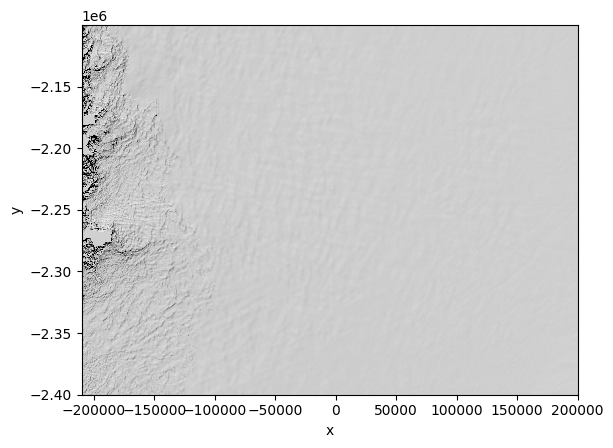

In [10]:
ds_dem = xr.open_dataset(Path("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc")).sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))
hs = hillshade(ds_dem["surface"], zf=5)
hs.plot(cmap="Greys_r", vmin=0, vmax=1, add_colorbar=False)

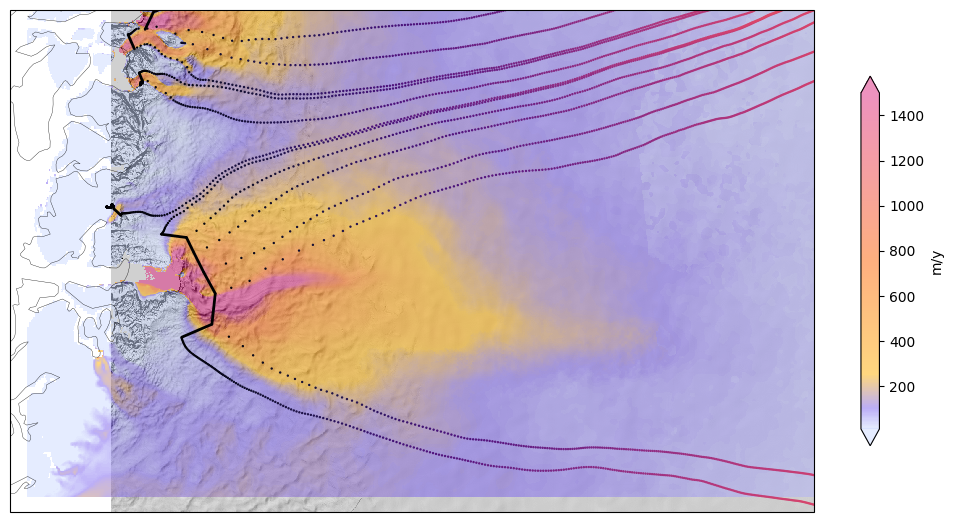

In [34]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)

jak_extent = {"x": slice(-240000, 60000), "y": slice(-2000000, -2350000)}

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=crs)


f = ds.sel(jak_extent)["v"].plot(vmin=10, vmax=1500, cmap=cmap, shading="flat", alpha=0.5, ax=ax,
                 transform=crs, 
             cbar_kwargs={"location": "right", "orientation": "vertical", 
                          "fraction": 0.085, "shrink": 0.6, "label": ds["v"].units},
)
hs.plot(cmap="Greys_r", vmin=0, vmax=1, ax=f.axes, zorder=-1, add_colorbar=False)
f.axes.coastlines(linewidth=0.25, resolution="10m")
t_l = result.plot(ax=f.axes, column="distance_from_origin", markersize=0.5, cmap="magma",
                  legend=False)
stp.plot(ax=ax, color="k", lw=2)
f.axes.set_extent([-51, -44, 68.5, 70])

In [12]:
result.plot?

Signature:      result.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x297621f40>
File:           ~/miniconda3/envs/pypism/lib/python3.12/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
kind: str
    The kind of plots to produce. The default is to create a map ("geo").
    Other supported kinds of plots from pandas:

    - 'line' : line plot
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : BoxPlot
    -

In [ ]:
h.where(h > 0, h, 0)

In [ ]:
h

In [ ]:
from matplotlib import colors, cm
from matplotlib.colors import LightSource

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)

In [ ]:
plt.imshow(ls.blend_overlay(ds["v"].to_numpy(), ds_dem["surface"].to_numpy()))

In [ ]:
ls.blend_overlay?

In [15]:
import blend_modes

In [12]:
norm = colors.Normalize(vmin=10.0, vmax=1500.0)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
speed_img = mapper.to_rgba

In [24]:
speed_img = mapper.to_rgba(ds.sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))["v"])

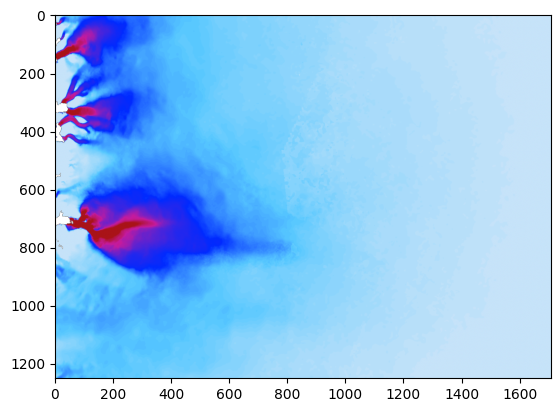

In [65]:
plt.imshow(np.array(speed_img))

In [25]:
g_norm = colors.Normalize(vmin=0.0, vmax=1)
g_mapper = cm.ScalarMappable(norm=g_norm, cmap="Greys_r")
hs_img = g_mapper.to_rgba(hs.to_numpy())

In [26]:
blend_modes.multiply(np.array(hs_img), np.array(speed_img), opacity=1.0)

ValueError: operands could not be broadcast together with shapes (2000,2734) (1250,1708) 

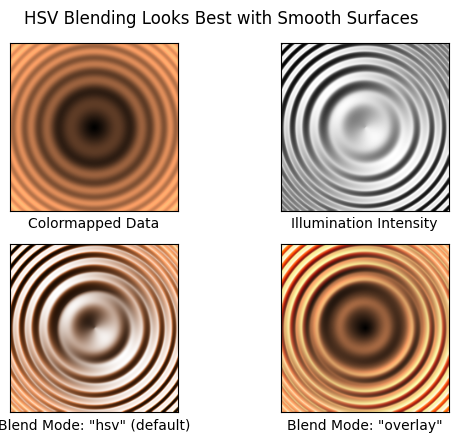

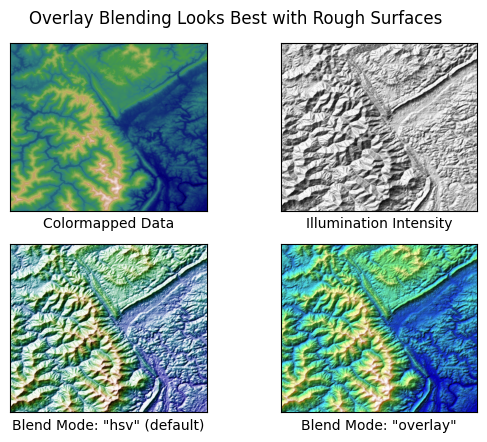

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib.cbook import get_sample_data

# Example showing how to make shaded relief plots
# like Mathematica
# (http://reference.wolfram.com/mathematica/ref/ReliefPlot.html)
# or Generic Mapping Tools
# (http://gmt.soest.hawaii.edu/gmt/doc/gmt/html/GMT_Docs/node145.html)


def main():
    # Test data
    x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
    z = 5 * (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))

    filename = get_sample_data('jacksboro_fault_dem.npz', asfileobj=False)
    with np.load(filename) as dem:
        elev = dem['elevation']

    fig = compare(z, plt.cm.copper)
    fig.suptitle('HSV Blending Looks Best with Smooth Surfaces', y=0.95)

    fig = compare(elev, plt.cm.gist_earth, ve=0.05)
    fig.suptitle('Overlay Blending Looks Best with Rough Surfaces', y=0.95)

    plt.show()


def compare(z, cmap, ve=1):
    # Create subplots and hide ticks
    fig, axes = plt.subplots(ncols=2, nrows=2)
    for ax in axes.flat:
        ax.set(xticks=[], yticks=[])

    # Illuminate the scene from the northwest
    ls = LightSource(azdeg=315, altdeg=45)

    axes[0, 0].imshow(z, cmap=cmap)
    axes[0, 0].set(xlabel='Colormapped Data')

    axes[0, 1].imshow(ls.hillshade(z, vert_exag=ve), cmap='gray')
    axes[0, 1].set(xlabel='Illumination Intensity')

    rgb = ls.shade(z, cmap=cmap, vert_exag=ve, blend_mode='hsv')
    axes[1, 0].imshow(rgb)
    axes[1, 0].set(xlabel='Blend Mode: "hsv" (default)')

    rgb = ls.shade(z, cmap=cmap, vert_exag=ve, blend_mode='overlay')
    axes[1, 1].imshow(rgb)
    axes[1, 1].set(xlabel='Blend Mode: "overlay"')

    return fig

if __name__ == '__main__':
    main()

In [30]:
ls.shade?

Object `ls.shade` not found.


In [31]:
    # Illuminate the scene from the northwest
    ls = LightSource(azdeg=315, altdeg=45)


In [78]:
jak_ds

<xarray.Dataset>
Dimensions:              (x: 1708, y: 1250)
Coordinates:
  * x                    (x) float64 -2.099e+05 -2.096e+05 ... 1.998e+05
  * y                    (y) float64 -2.1e+06 -2.1e+06 ... -2.4e+06 -2.4e+06
Data variables: (12/14)
    vx                   (y, x) float32 ...
    vy                   (y, x) float32 ...
    v                    (y, x) float32 0.8681 3.334 5.781 ... 7.888 7.939 7.993
    vx_err               (y, x) float32 ...
    vy_err               (y, x) float32 ...
    v_err                (y, x) float32 ...
    ...                   ...
    count                (y, x) float32 ...
    chip_size_max        (y, x) float32 ...
    ocean                (y, x) float32 ...
    rock                 (y, x) float32 ...
    ice                  (y, x) float32 ...
    Polar_Stereographic  |S1 ...
Attributes:
    GDAL_AREA_OR_POINT:       Area
    date_created:             30-Apr-2019 06:39:34
    title:                    autoRIFT surface velocities
    author:                   Alex S. Gardner, JPL/NASA
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    scene_pair_type:          optical
    motion_detection_method:  feature
    motion_coordinates:       map

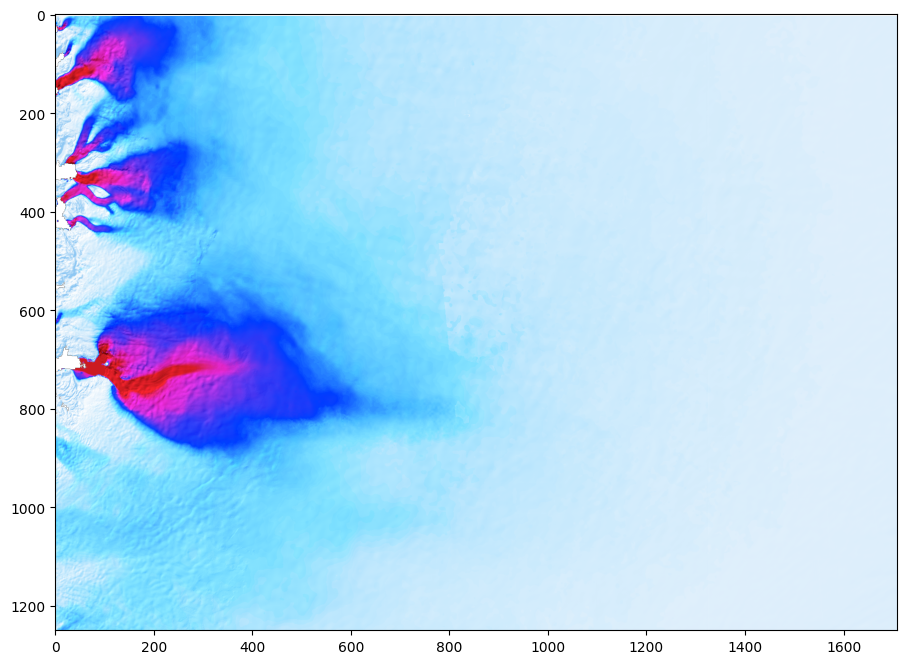

In [99]:
jak_ds = ds.sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))
jak_speed = jak_ds["v"].to_numpy()
jak_surface = ds_dem["surface"].interp_like(jak_ds).to_numpy()

norm = colors.Normalize(vmin=10.0, vmax=1500.0)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
speed_img = mapper.to_rgba(jak_speed)

ls = LightSource(azdeg=315, altdeg=45)
z = jak_surface
v = jak_speed
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
#ax.imshow(z, cmap=cmap)
#ax.imshow(ls.hillshade(z, vert_exag=0.01), cmap='gray')
rgb = ls.shade_rgb(speed_img, elevation=z, vert_exag=0.025, blend_mode='overlay')
ax.imshow(rgb)


In [93]:
hs = hillshade(ds_dem["surface"].interp_like(jak_ds), normalize=True)
blend_modes.multiply(np.array(hs_img), np.array(speed_img), opacity=1.0)

ValueError: operands could not be broadcast together with shapes (2000,2734) (1250,1708) 

In [91]:
jak_surface

array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [ 514.61069484,  497.47688378,  486.51219217, ..., 3023.88572693,
        3024.07286126, 3024.41904853],
       [ 540.86837285,  523.46917809,  516.56738148, ..., 3023.47784288,
        3023.4902832 , 3023.52310967],
       ...,
       [ 580.1839581 ,  580.24845111,  584.94329283, ..., 2649.04043342,
        2648.2332428 , 2648.1131958 ],
       [ 583.15714383,  589.99355525,  598.90231072, ..., 2648.19873488,
        2648.11691081, 2648.11046143],
       [ 586.859164  ,  597.60168996,  607.41621485, ..., 2648.08452793,
        2647.91941827, 2647.34484789]])

In [98]:
def hillshade(
    dem: xr.DataArray,
    altitude: float = 45,
    azimuth: float = 45.0,
    fill_value: float = 0.0,
    zf: float = 1.0,
    normalize: bool = False,
) -> xr.DataArray:
    """
    shaded relief using the ESRI algorithm
    """

    azimuth = 360.0 - azimuth + 90  # convert to mathematic unit
    if (azimuth > 360) or (azimuth == 360):
        azimuth = azimuth - 360
    azimuth = azimuth * (np.pi / 180)  # convert to radians

    # lighting altitude
    altitude = (90 - altitude) * (np.pi / 180)  # convert to zenith angle in radians

    # calc slope and aspect (radians)
    fx = dem.differentiate(coord="x")
    fy = dem.differentiate(coord="y")
    [asp, grad] = cart2pol(fy, fx)  # convert to carthesian coordinates

    grad = np.arctan(zf * grad)  # steepest slope
    # convert asp
    asp = asp.where(asp < np.pi, asp + (np.pi / 2))
    asp = asp.where(asp < 0, asp + (np.pi / 2))

    ## hillshade calculation
    h = 255.0 * (
        (np.cos(altitude) * np.cos(grad))
        + (np.sin(altitude) * np.sin(grad) * np.cos(azimuth - asp))
    )
    h = h.where(h > 0, h, 0)

    if normalize:
        h = h / 255.0  # normalize to 0-1
    h.name = "hillshade"
    h.attrs["units"] = "1"
    return h


In [100]:
da = xr.DataArray(
    np.sin(0.3 * np.arange(20).reshape(5, 4)),
    [("x", np.arange(5)), ("y", [0.1, 0.2, 0.3, 0.4])],
)

In [101]:
da

<xarray.DataArray (x: 5, y: 4)>
array([[ 0.        ,  0.29552021,  0.56464247,  0.78332691],
       [ 0.93203909,  0.99749499,  0.97384763,  0.86320937],
       [ 0.67546318,  0.42737988,  0.14112001, -0.15774569],
       [-0.44252044, -0.68776616, -0.87157577, -0.97753012],
       [-0.99616461, -0.92581468, -0.77276449, -0.55068554]])
Coordinates:
  * x        (x) int64 0 1 2 3 4
  * y        (y) float64 0.1 0.2 0.3 0.4

In [111]:
x_a = np.array([0.5, 1.5, 2.5, 3.5])
y_a = np.array([0.15, 0.25, 0.35, 0.45])
profile_axis = np.sqrt(x_a**2 + y_a**2)
profile_axis -= profile_axis[0]
x = xr.DataArray(x_a, dims="profile_axis", coords={"profile_axis": profile_axis})
y = xr.DataArray(y_a, dims="profile_axis", coords={"profile_axis": profile_axis}
)

da = ds_o
da.interp(x=x, y=y, kwargs={"fill_value": None})

<xarray.DataArray (profile_axis: 4)>
array([ 0.55626357,  0.63496063, -0.46643289, -0.73507668])
Coordinates:
    x             (profile_axis) float64 0.5 1.5 2.5 3.5
    y             (profile_axis) float64 0.15 0.25 0.35 0.45
  * profile_axis  (profile_axis) float64 0.0 0.9987 2.002 3.007

In [112]:
da.interp?

Signature:
da.interp(
    coords: 'Mapping[Any, Any] | None' = None,
    method: 'InterpOptions' = 'linear',
    assume_sorted: 'bool' = False,
    kwargs: 'Mapping[str, Any] | None' = None,
    **coords_kwargs: 'Any',
) -> 'Self'
Docstring:
Interpolate a DataArray onto new coordinates

Performs univariate or multivariate interpolation of a DataArray onto
new coordinates using scipy's interpolation routines. If interpolating
along an existing dimension, :py:class:`scipy.interpolate.interp1d` is
called. When interpolating along multiple existing dimensions, an
attempt is made to decompose the interpolation into multiple
1-dimensional interpolations. If this is possible,
:py:class:`scipy.interpolate.interp1d` is called. Otherwise,
:py:func:`scipy.interpolate.interpn` is called.

Parameters
----------
coords : dict, optional
    Mapping from dimension names to the new coordinates.
    New coordinate can be a scalar, array-like or DataArray.
    If DataArrays are passed as new coordinates,

In [113]:
result

,vx,vy,v,trai_id,traj_pt,distance,distance_from_origin,id,name,length,clon,clat,flightline,gtype,ftype,basin,perturbation,geometry
0,-23.541098,-21.751166,32.051466,0,0,0.000000,0.000000,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,0,POINT (-192247.149 -2256072.076)
1,-24.772772,-24.080637,34.548044,0,1,331.735187,331.735187,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,0,POINT (-192005.196 -2255845.124)
2,-24.695036,-30.034843,38.883629,0,2,365.269854,697.005041,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,0,POINT (-191756.535 -2255577.562)
3,-23.464229,-37.328463,44.090636,0,3,416.059196,1113.064237,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,0,POINT (-191514.928 -2255238.842)
4,-21.202618,-42.946570,47.895291,0,4,459.560112,1572.624349,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,0,POINT (-191289.834 -2254838.182)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17029,-12.570560,-3.332738,13.004850,1,997,130.044545,387587.655246,33,Sermeq Kujalleq,7471,NaN,NaN,0,0,0,7.2,0,POINT (176188.255 -2100644.123)
17030,-12.588936,-3.245764,13.000627,1,998,130.040896,387717.696142,33,Sermeq Kujalleq,7471,NaN,NaN,0,0,0,7.2,0,POINT (176314.074 -2100611.254)
17031,-12.588564,-3.174847,12.982742,1,999,129.928051,387847.624193,33,Sermeq Kujalleq,7471,NaN,NaN,0,0,0,7.2,0,POINT (176439.973 -2100579.151)
17032,-12.569619,-3.116735,12.950265,1,1000,129.686690,387977.310883,33,Sermeq Kujalleq,7471,NaN,NaN,0,0,0,7.2,0,POINT (176565.795 -2100547.726)


In [116]:
gp.GeoDataFrame(geometry=[(0, 1), (0, 2)])

TypeError: Input must be valid geometry objects: (0, 1)

In [23]:
[f[1]  for f in jak_extent.items()]

[slice(-240000, 60000, None), slice(-2000000, -2350000, None)]

In [20]:
jak_extent.items()

dict_items([('x', slice(-240000, 60000, None)), ('y', slice(-2000000, -2350000, None))])

In [31]:
stp

,id,name,length,clon,clat,flightline,gtype,ftype,basin,geometry
0,1,Jakobshavn Isbræ,54145,-54.4415,68.91886,1,0,0,7.1,"LINESTRING (-192247.149 -2256072.076, -183200...."
1,2,Sermeq Avannarleq,9529,-55.5484,70.08350,0,0,0,7.2,"LINESTRING (-199879.996 -2161653.551, -193167...."
2,30,Sermeq Avannarleq 2,3894,NaN,NaN,0,0,0,7.2,"LINESTRING (-209258.011 -2246873.489, -206589...."
3,31,Eqip Sermia,3535,NaN,NaN,0,0,0,7.2,"LINESTRING (-200124.317 -2198414.219, -198854...."
4,32,Kangilerngata Sermia,6598,NaN,NaN,0,0,0,7.2,"LINESTRING (-204072.164 -2184766.266, -201782...."
5,33,Sermeq Kujalleq,7471,NaN,NaN,0,0,0,7.2,"LINESTRING (-194829.232 -2176417.328, -198001...."
